# Supervised learning - Classification
Goal of the excercise is to learn how to use Scikit-learn library for a classification tasks using Decision tree and SVM and moreover evaluate the performance of the proposed models.

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, auc
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC

#### Data Dictionary

|Variable|Definition|Key|
|:-------|:-------|:--------|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex||
|Age|Age in years||
|sibsp|# of siblings / spouses aboard the Titanic||
|parch|# of parents / children aboard the Titanic||
|ticket|Ticket number||
|fare|Passenger fare||
|cabin|Cabin number||
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

- Decision tree https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- Train test split https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- Accuracy https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
- Metrics https://scikit-learn.org/stable/modules/model_evaluation.html
- K-Fold CV https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
- SVM https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

## Load the titanic.csv dataset
- We want to create a model that predicts if a certain passanger survives or not, thus **survival** is the class label in this case

In [8]:
df = pd.read_csv('data/titanic.csv', index_col=0)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


## How many passangers survived?

In [9]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

## We need to pre-process the data first
- We want to use only numerical attributes as a model features
- Certain attributes need to be dropped and some of them can be encoded

### Which features would you drop and why?
### Which features could be encoded and which methods would you use?

In [10]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [11]:
df.describe(exclude=np.number)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Fox, Mr. Stanley Hubert",male,CA. 2343,G6,S
freq,1,577,7,4,644


In [12]:
df.describe(include=np.number)

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## How many values are missing in the individual attributes?

In [13]:
df.isna().sum().sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
Fare          0
Ticket        0
Parch         0
SibSp         0
Sex           0
Name          0
Pclass        0
Survived      0
dtype: int64

## Let's drop Name and Ticket features - these have no use for us now

In [14]:
df = df.drop(['Name', 'Ticket'], axis=1)
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN,S
2,1,1,female,38.0,1,0,71.2833,C85,C
3,1,3,female,26.0,0,0,7.9250,NaN,S
4,1,1,female,35.0,1,0,53.1000,C123,S
5,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,NaN,S
888,1,1,female,19.0,0,0,30.0000,B42,S
889,0,3,female,NaN,1,2,23.4500,NaN,S


## Extract the deck identifier from the Cabin feature
- Note: A = top deck, G = lowest deck
- Change type to string
- Filter the first letter using *apply* function
- If the value is *nan* use *U* value as an replacement - this will mark the passangers with missing Cabin value
- Replace the T value with A

In [15]:
df.Cabin = df.Cabin.astype(str).apply(lambda x: x[0] if x != 'nan' else 'U').replace({'T': 'A'})

In [16]:
df.Cabin.value_counts()

U    687
C     59
B     47
D     33
E     32
A     16
F     13
G      4
Name: Cabin, dtype: int64

## The Age feature is tricky, we have multiple solutions for this, e.g.:
- Drop the feature
- Take the mean/median value to replace the missing value
- Take a random list of ages that maintains the original statistical summary values.
- Use a model to predict values based on the existing values.

### We will use the second option

<AxesSubplot:ylabel='Age'>

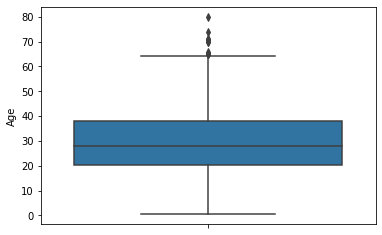

In [17]:
sns.boxplot(y=df.Age)

In [18]:
df.Age = df.Age.fillna(df.Age.mean())

<AxesSubplot:ylabel='Age'>

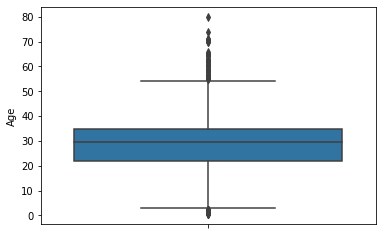

In [19]:
sns.boxplot(y=df.Age)

## Two passangers don't have the Embarked filled - we can drop these two rows

In [20]:
df = df.dropna().copy()

In [21]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,male,22.000000,1,0,7.2500,U,S
2,1,1,female,38.000000,1,0,71.2833,C,C
3,1,3,female,26.000000,0,0,7.9250,U,S
4,1,1,female,35.000000,1,0,53.1000,C,S
5,0,3,male,35.000000,0,0,8.0500,U,S
...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.000000,0,0,13.0000,U,S
888,1,1,female,19.000000,0,0,30.0000,B,S
889,0,3,female,29.699118,1,2,23.4500,U,S


## The last step of the pre-processing pipeline is to encode Sex, Cabin and Embarked features
- We will use one-hot encoding for Sex and Embarked and Ordinal encoding for Cabin
- Specify the encoding scheme for the ordinal encoding using an array in a form ['first', 'second', 'third', ...]

In [22]:
cabin_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'U']
enc_cabin = OrdinalEncoder(categories=[cabin_categories])
enc_cabin.fit_transform(df[['Cabin']])[:, 0]

array([7., 2., 7., 2., 7., 7., 4., 7., 7., 7., 6., 2., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 3., 7., 0., 7., 7., 7., 2., 7., 7., 7., 1., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 3., 7., 1., 2., 7., 7., 7., 7., 7., 2., 7., 7., 7., 5., 7., 7.,
       7., 7., 7., 7., 7., 7., 5., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 2., 7., 7., 7., 4., 7., 7., 7., 0., 3., 7., 7., 7., 7., 3.,
       7., 7., 7., 7., 7., 7., 7., 2., 7., 7., 7., 7., 7., 7., 7., 1., 7.,
       7., 7., 7., 4., 3., 7., 7., 7., 5., 7., 7., 7., 7., 7., 7., 7., 3.,
       2., 7., 1., 7., 7., 7., 7., 7., 7., 7., 7., 5., 7., 7., 2., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 4., 7., 7., 7., 1.,
       7., 7., 7., 0., 7., 7., 2., 7., 7., 7., 7., 7., 5., 7., 0., 7., 7.,
       7., 7., 7., 7., 7., 5., 1., 1., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       6., 7., 7., 7., 0., 7., 7., 7., 7., 7., 3., 7., 7., 3., 7., 7., 7.,
       7., 7., 2., 7., 7.

In [23]:
df['Cabin'] = enc_cabin.fit_transform(df[['Cabin']])[:, 0]

In [24]:
sex_categories = ['male', 'female']
enc_sex = OrdinalEncoder(categories=[sex_categories])
df['Sex'] = enc_sex.fit_transform(df[['Sex']])[:, 0]

In [25]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
1,0,3,0.0,22.0,1,0,7.2500,7.0,S
2,1,1,1.0,38.0,1,0,71.2833,2.0,C
3,1,3,1.0,26.0,0,0,7.9250,7.0,S
4,1,1,1.0,35.0,1,0,53.1000,2.0,S
5,0,3,0.0,35.0,0,0,8.0500,7.0,S


In [26]:
pd.get_dummies(df['Embarked'], prefix='Embarked')

,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1
5,0,0,1
...,...,...,...
887,0,0,1
888,0,0,1
889,0,0,1


In [27]:
df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked')], axis=1).drop('Embarked', axis=1)

## Now we have the data ready

In [28]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,3,0.0,22.000000,1,0,7.2500,7.0,0,0,1
2,1,1,1.0,38.000000,1,0,71.2833,2.0,1,0,0
3,1,3,1.0,26.000000,0,0,7.9250,7.0,0,0,1
4,1,1,1.0,35.000000,1,0,53.1000,2.0,0,0,1
5,0,3,0.0,35.000000,0,0,8.0500,7.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0.0,27.000000,0,0,13.0000,7.0,0,0,1
888,1,1,1.0,19.000000,0,0,30.0000,1.0,0,0,1
889,0,3,1.0,29.699118,1,2,23.4500,7.0,0,0,1


## Let's start with splitting the data into the input and output part
- Usually named as a *X* and *y* variables

In [29]:
X, y = df.loc[:, df.columns != 'Survived'], df.loc[:, 'Survived']

In [30]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,3,0.0,22.0,1,0,7.2500,7.0,0,0,1
2,1,1.0,38.0,1,0,71.2833,2.0,1,0,0
3,3,1.0,26.0,0,0,7.9250,7.0,0,0,1
4,1,1.0,35.0,1,0,53.1000,2.0,0,0,1
5,3,0.0,35.0,0,0,8.0500,7.0,0,0,1


In [31]:
y.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

## Lets continue with train test split process.
- Use .shape
- Note that number of rows in the *X* and *y* in the Train/Test part of the data has to be equal

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.5)

## Create the Decision tree classifier instance

In [33]:
clf = DecisionTreeClassifier()

### Use *fit()* method for training of classifier

In [34]:
clf = clf.fit(X_train, y_train)

### Lets use trained model for the prediction part
- Get predictions via the method *predict()*

In [35]:
y_pred = clf.predict(X_test)

$ConfMatrix = \begin{bmatrix}
TP & FN\\
FP & TN
\end{bmatrix}$

In [36]:
accuracy_score(y_test, y_pred)

0.7595505617977528

## What does the confusion matrix tell us?
- Where do we find true positives, false positives etc?

<AxesSubplot:>

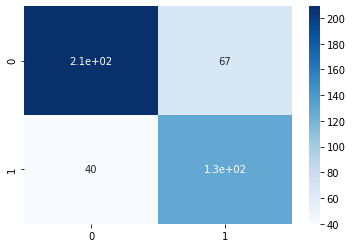

In [37]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues")

In [38]:
accuracy_score(y_test, y_pred)

0.7595505617977528

In [39]:
precision_score(y_test, y_pred)

0.6581632653061225

In [40]:
recall_score(y_test, y_pred)

0.7633136094674556

In [41]:
f1_score(y_test, y_pred)

0.706849315068493

## Can we improve our evaluation process?
- Lets try crossvalidation process for decision tree model
- https://scikit-learn.org/stable/modules/cross_validation.html
- **What is the difference between Pure and Stratified K-Fold?**

In [42]:
skf = KFold(n_splits=5)
scores = list()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    print(f'Survival ratio in train set: {y_train.value_counts(normalize=True)[1]:.2}; Survival ratio in test set: {y_test.value_counts(normalize=True)[1]:.2}')
scores

Survival ratio in train set: 0.4; Survival ratio in test set: 0.33
Survival ratio in train set: 0.37; Survival ratio in test set: 0.44
Survival ratio in train set: 0.38; Survival ratio in test set: 0.39
Survival ratio in train set: 0.38; Survival ratio in test set: 0.4
Survival ratio in train set: 0.39; Survival ratio in test set: 0.35


[0.6349206349206349,
 0.7500000000000001,
 0.7445255474452556,
 0.6417910447761195,
 0.7786259541984734]

In [43]:
skf = StratifiedKFold(n_splits=5)
scores = list()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    print(f'Survival ratio in train set: {y_train.value_counts(normalize=True)[1]:.2}; Survival ratio in test set: {y_test.value_counts(normalize=True)[1]:.2}')
    
scores

Survival ratio in train set: 0.38; Survival ratio in test set: 0.38
Survival ratio in train set: 0.38; Survival ratio in test set: 0.38
Survival ratio in train set: 0.38; Survival ratio in test set: 0.38
Survival ratio in train set: 0.38; Survival ratio in test set: 0.38
Survival ratio in train set: 0.38; Survival ratio in test set: 0.38


[0.6521739130434783,
 0.7246376811594202,
 0.7272727272727272,
 0.6976744186046512,
 0.7887323943661971]

In [44]:
np.mean(scores), np.min(scores), np.max(scores)

(0.7180982268892947, 0.6521739130434783, 0.7887323943661971)

In [45]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
scores = list()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred))
    
scores

[0.6769230769230768,
 0.7518796992481205,
 0.7424242424242423,
 0.7338129496402879,
 0.7007299270072992]

In [46]:
np.mean(scores), np.min(scores), np.max(scores)

(0.7211539790486053, 0.6769230769230768, 0.7518796992481205)

# Let's try another algorithm - SVM
- SVM - https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- SVM demo 1 - https://www.csie.ntu.edu.tw/~cjlin/libsvm/
- SVM demo 2 - https://cs.stanford.edu/~karpathy/svmjs/demo/

### Task (2b)
- Take a look at the parameters of the SVM
- e.g. C, kernel
- **Try at least 5 different parameter's configurations**, use both linear and RBF kernel, you can also experiment with other
- Tune the hyper-parameters and compare classification results after crossvalidation validation step
    - **Write down to markdown cell which is better and why!**


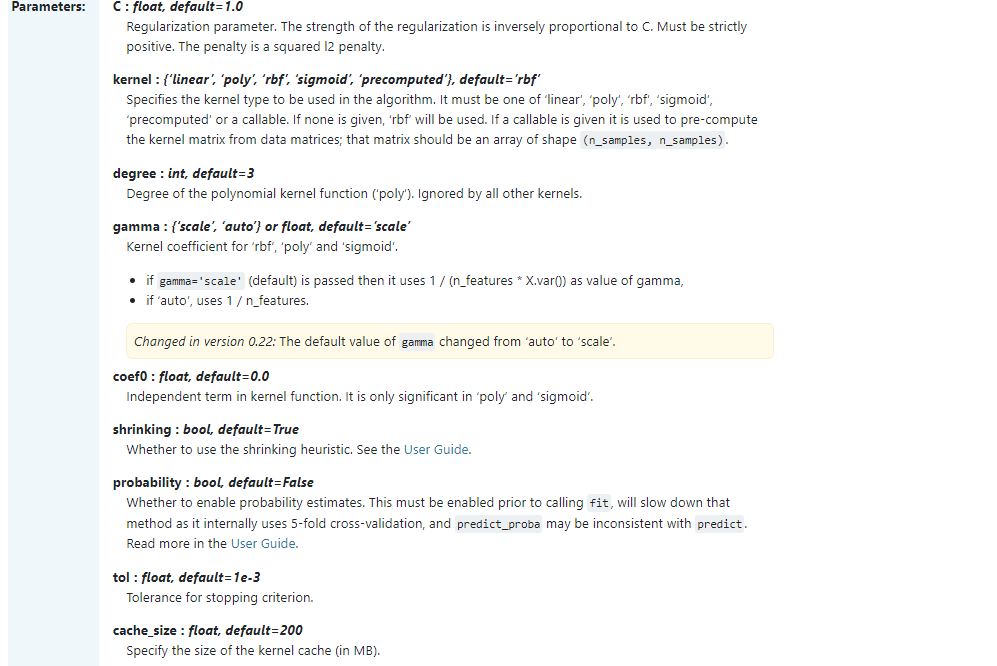

### Solution

kernel : ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’

In [47]:
from sklearn.model_selection import cross_val_score

In [48]:
configutaions = (
    {
        'gamma': 'auto',
        'kernel': 'linear',
        'C': 10
    },
    {
        'gamma': 'auto',
        'kernel': 'linear',
        'C': 20
    },
    {
        'gamma': 'auto',
        'kernel': 'linear',
        'C': 50
    },
    {
        'gamma': 'auto',
        'kernel': 'rbf',
        'C': 100
    },
    {
        'gamma': 'auto',
        'kernel': 'rbf',
        'C': 10
    },
    {
        'gamma': 'auto',
        'kernel': 'rbf',
        'C': 50
    },

)

In [49]:
configutaions

({'gamma': 'auto', 'kernel': 'linear', 'C': 10},
 {'gamma': 'auto', 'kernel': 'linear', 'C': 20},
 {'gamma': 'auto', 'kernel': 'linear', 'C': 50},
 {'gamma': 'auto', 'kernel': 'rbf', 'C': 100},
 {'gamma': 'auto', 'kernel': 'rbf', 'C': 10},
 {'gamma': 'auto', 'kernel': 'rbf', 'C': 50})

In [50]:
def run_experiments(configurations, X, y):
    results = {}
    print(f'running all experiments {configurations}')
    for index, conf in enumerate(configurations):
        print(f'Experiment {index}: {conf} ')
        clf = SVC(**conf)
        scores = cross_val_score(clf, X, y, cv=3)
        results[index] = (conf ,scores)
    return results

In [51]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,3,0.0,22.000000,1,0,7.2500,7.0,0,0,1
2,1,1.0,38.000000,1,0,71.2833,2.0,1,0,0
3,3,1.0,26.000000,0,0,7.9250,7.0,0,0,1
4,1,1.0,35.000000,1,0,53.1000,2.0,0,0,1
5,3,0.0,35.000000,0,0,8.0500,7.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
887,2,0.0,27.000000,0,0,13.0000,7.0,0,0,1
888,1,1.0,19.000000,0,0,30.0000,1.0,0,0,1
889,3,1.0,29.699118,1,2,23.4500,7.0,0,0,1


In [57]:
y.value_counts()

0    549
1    340
Name: Survived, dtype: int64

In [52]:
results = run_experiments(configutaions, X, y)

running all experiments ({'gamma': 'auto', 'kernel': 'linear', 'C': 10}, {'gamma': 'auto', 'kernel': 'linear', 'C': 20}, {'gamma': 'auto', 'kernel': 'linear', 'C': 50}, {'gamma': 'auto', 'kernel': 'rbf', 'C': 100}, {'gamma': 'auto', 'kernel': 'rbf', 'C': 10}, {'gamma': 'auto', 'kernel': 'rbf', 'C': 50})
Experiment 0: {'gamma': 'auto', 'kernel': 'linear', 'C': 10} 
Experiment 1: {'gamma': 'auto', 'kernel': 'linear', 'C': 20} 
Experiment 2: {'gamma': 'auto', 'kernel': 'linear', 'C': 50} 
Experiment 3: {'gamma': 'auto', 'kernel': 'rbf', 'C': 100} 
Experiment 4: {'gamma': 'auto', 'kernel': 'rbf', 'C': 10} 
Experiment 5: {'gamma': 'auto', 'kernel': 'rbf', 'C': 50} 


In [53]:
def print_result(index, result):
    conf, scores = result
    print(f'Configuration {index} -> {conf} \n \tMax - {np.max(scores)} \n\tMin - {np.min(scores)} \n\tMean - {np.mean(scores)}' )

In [54]:
def print_results(results):
    for index, result in enumerate(results.values()):
        print_result(index, result)

In [55]:
print_results(results)

Configuration 0 -> {'gamma': 'auto', 'kernel': 'linear', 'C': 10} 
 	Max - 0.8006756756756757 
	Min - 0.7702702702702703 
	Mean - 0.787397245730579
Configuration 1 -> {'gamma': 'auto', 'kernel': 'linear', 'C': 20} 
 	Max - 0.7972972972972973 
	Min - 0.7702702702702703 
	Mean - 0.7851487851487851
Configuration 2 -> {'gamma': 'auto', 'kernel': 'linear', 'C': 50} 
 	Max - 0.793918918918919 
	Min - 0.7702702702702703 
	Mean - 0.7851449934783269
Configuration 3 -> {'gamma': 'auto', 'kernel': 'rbf', 'C': 100} 
 	Max - 0.7364864864864865 
	Min - 0.6993243243243243 
	Mean - 0.7131715048381716
Configuration 4 -> {'gamma': 'auto', 'kernel': 'rbf', 'C': 10} 
 	Max - 0.7138047138047138 
	Min - 0.6959459459459459 
	Mean - 0.7030249946916615
Configuration 5 -> {'gamma': 'auto', 'kernel': 'rbf', 'C': 50} 
 	Max - 0.7364864864864865 
	Min - 0.6993243243243243 
	Mean - 0.7120491703825037


**Write down to markdown cell which is better and why!**


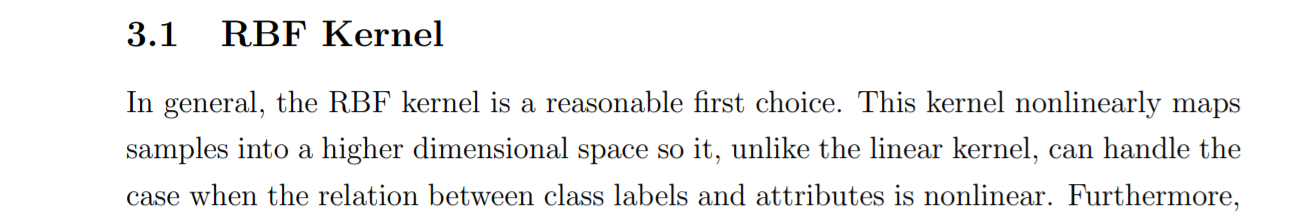

- Lépe vychází lineární kernel.
- RBF kernel běžel mnohem déle.
- S nižším C měla lineární konfigurace lepší výsledky.
- Důvod: netuším.. :-D

Vysvětlení: závislost mezi daty není lineární, proč pak vychází lépe lineární kernel? neměl by RBF vycházet lépe?